Check construction data against other sources

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import sys; sys.path.append('../scripts')
from util import load_dataframe

flows = pd.read_csv('../data/flows.csv')

ISSB_DP = '../build/input_data/uk-issb-statistics-v1.0.0.zip'
issb_deliveries = load_dataframe(ISSB_DP, 'deliveries')

First, all UK demand, including imports:

In [2]:
construction_demand = flows \
    .query('source == "products 14" and target == "uk_demand"') \
    .set_index('year')['value']
    #.groupby(['year', 'material'])['value'].sum() \
    #.unstack() \
    #[sectors]
    
construction_manufac_uk = flows \
    .query('source == "uk_production" and target == "sector 14"') \
    .set_index(['year', 'material'])['value'] \
    .unstack() \
    .fillna(0)

construction_manufac_imports = flows \
    .query('source == "imports" and target == "sector 14"') \
    .set_index(['year', 'material'])['value'] \
    .unstack() \
    .fillna(0)

construction_manufac_all = construction_manufac_uk.add(construction_manufac_imports, fill_value=0)

For comparison, home deliveries to construction from the ISSB data:

In [3]:
deliveries = issb_deliveries \
    .query('sector_code == "14"') \
    .set_index(['year', 'product'])['mass'] \
    .unstack() \
    .fillna(0)

#deliveries

In [4]:
deliveries.sum(axis=1)

year
1985     327.6
1990    1006.5
1996     680.8
1998     674.6
2003     611.4
2007     703.8
2008     708.0
dtype: float64

Ley gives longer-term time series for steel products used in construction. Compare them to the total values in our model:

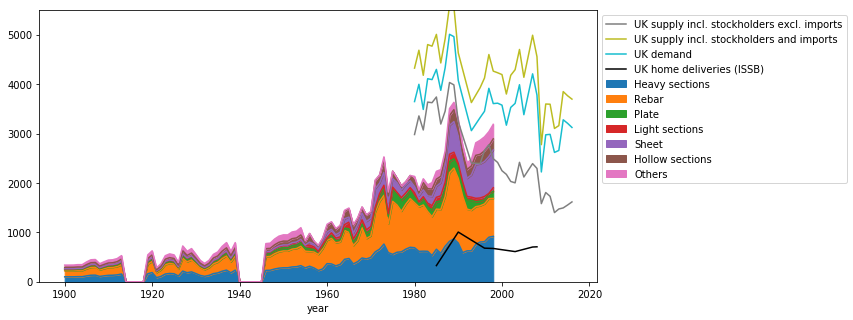

In [5]:
ley = pd.read_excel('./Ley_construction.xlsx', index_col='Year')
ley.plot.area(figsize=(10, 5));
construction_manufac_uk.sum(axis=1).plot(label='UK supply incl. stockholders excl. imports');
construction_manufac_all.sum(axis=1).plot(label='UK supply incl. stockholders and imports');
construction_demand.plot(label='UK demand');
deliveries.sum(axis=1).plot(color='k', label='UK home deliveries (ISSB)');
plt.legend(bbox_to_anchor=(1, 1));
plt.ylim(0, 5500);

Compare proportions of products, first in Ley's data:

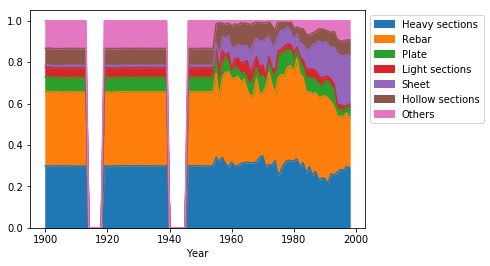

In [6]:
ley_proportions = (ley.T / ley.sum(axis=1)).T
ley_proportions.plot.area();
plt.legend(bbox_to_anchor=(1, 1));

Then in our data, for home deliveries (UK production):

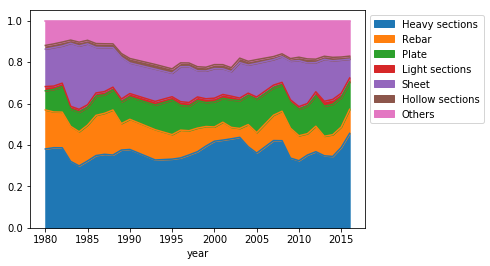

In [7]:
df = (construction_manufac_uk.T / construction_manufac_uk.sum(axis=1)).T

agg = {
    'Heavy sections': ['Heavy sections', 'Railway track material', 'Sheet piling and rolled accessories'],
    'Rebar': ['Reinforcing bar'],
    'Plate': ['Plate'],
    'Light sections': ['Light sections'],
    'Sheet': ['Cold rolled', 'Hot rolled'],
    'Hollow sections': ['Tubes and pipes'],
    'Others': ['Hot rolled bars in lengths', 'Rods']
}

uk_manufac_home_proportions = pd.DataFrame({
    k: sum(df[j] for j in items)
    for k, items in agg.items()
})

uk_manufac_home_proportions.plot.area();
plt.legend(bbox_to_anchor=(1, 1));

And for all deliveries (UK production + imports):

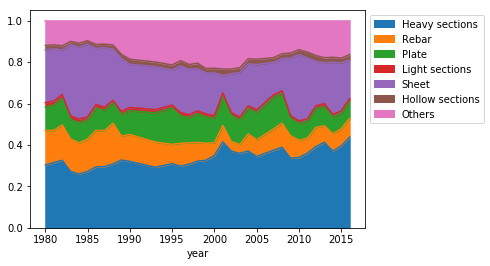

In [8]:
df = (construction_manufac_all.T / construction_manufac_all.sum(axis=1)).T
uk_manufac_all_proportions = pd.DataFrame({
    k: sum(df[j] for j in items)
    for k, items in agg.items()
})

uk_manufac_all_proportions.plot.area();
plt.legend(bbox_to_anchor=(1, 1));

It doesn't make a huge difference whether imports are included.

Overlay Ley's data and our data for home deliveries:

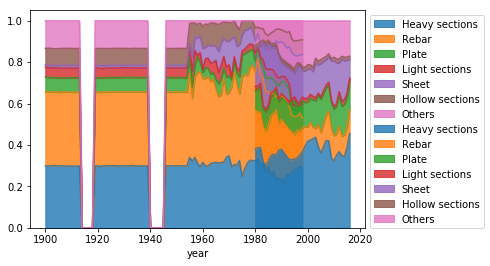

In [9]:
fig, ax = plt.subplots();
ley_proportions.plot.area(ax=ax, color=[f'C{i}' for i in range(7)], alpha=0.8);
uk_manufac_home_proportions.plot.area(ax=ax, color=[f'C{i}' for i in range(7)], alpha=0.8, label=None);
plt.legend(bbox_to_anchor=(1, 1));

Based on that, heavy sections are about right; there is not enough rebar in our dataset; there is too much "sheet" and "other".